In [1]:
import torch
from utils import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- We will adopt the `generate_text_simple` function from the previous chapter and introduce 2 new functions.
- `text_to_token_ids` and `token_ids_to_text`. These functions will help the conversion between text and token representations.

In [2]:
import tiktoken
from utils import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [3]:
# Example
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print(f"Output Text: {token_ids_to_text(token_ids, tokenizer)}")

Output Text: Every effort moves you rentingetic wasnم refres RexAngel infieldcigans


- The output is gibberish
- We will implement a numerical method to evaluate the generated content. This will allow is to monitor and enhance the model's performance throughout the training process.

# Calculating the text generation loss

In [4]:
# INPUTS
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
inputs = []
txt1 = "every effort moves"
txt2 = "I really like"

inputs.append(torch.tensor(tokenizer.encode(txt1)))
inputs.append(torch.tensor(tokenizer.encode(txt2)))
inputs = torch.stack(inputs, dim=0)
print("INPUTS:\n", inputs)


#TARGETS
targets = []
txt1 = " effort moves you"
txt2 = " really like chocolate"

targets.append(torch.tensor(tokenizer.encode(txt1)))
targets.append(torch.tensor(tokenizer.encode(txt2)))
targets = torch.stack(targets, dim=0)
print("OUTPUTS:\n", targets)


INPUTS:
 tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])
OUTPUTS:
 tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


In [5]:
# Lets get the logits
with torch.no_grad():
    logits = model(inputs)
    probas = torch.softmax(logits, dim=-1)
    print(probas.shape)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("TOKEN IDS:\n", token_ids)

TOKEN IDS:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2]]

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.2671e-05, 3.1046e-05, 1.1696e-05])
Text 2: tensor([1.0426e-05, 5.4604e-05, 4.7716e-06])


- Above are the probabilities of the each input token in the above 2 text examples.

# Back propagation
- Used to update the model weights
- Compute the negative log likelihood.

In [10]:
# Calculate log of each token across the entire batch
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5296, -10.3800, -11.3563, -11.4712,  -9.8154, -12.2528])


In [11]:
# Calculate the average of the log
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8009)


In [12]:
# Multiply by negative 1
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8009)


- This process performed above is known as cross-entropy loss.
- Pytorch has an in-built function to do that.

In [13]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- Logits are 3-D (batch_size, number of tokens, vocab-size)
- The targets tensor has 2-D (batch_size, number of tokens)
- For the cross_entropy we have to flatten by combining them over the batch dimension


In [14]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [15]:
# Using pytorch to calculate the loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8009)


# Perplexity
- Its a measure that is often used to evaluate the performance of models in tasks like language modeling.
- Provides a more interpretable way to understand the uncertainity of model in predicting the next token in a sequence.
- Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of words in the dataset. Similar to loss, a lower perplexity indicated that the model predictions are closer to the actual distribution.
- It signifies the effective vocabulary size about which the model is uncertain at each step.
- This would translate to the model being unsure about which among all the tokens in the vocabulary to generate as the next token.

In [16]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(49064.1680)


So in the above excercise we have computed the loss and perplexity to 2 inputs. But we will now extend it to the entire training and validation sets.

# Calculating the training and validation set losses.

In [17]:
# Lets first prepare the training and validation datasets.
# We will use the same dataset we had used in earlier chapter ("The Verdict")

In [19]:
file_path = 'data/chapter2/the-verdict.txt'
# file_path = 'data/tinystories.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()    

In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Number of Characters: {total_characters}")
print(f"Number of Tokens: {total_tokens}")

Number of Characters: 20479
Number of Tokens: 5145


- We will split the data in to training and validation sets.
- They will be tokenized
- Sample will be generated of `context_length`
- Samples will be grouped to form batches (with shuffling)

In [21]:
train_ratio = 0.95
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [22]:
# We can now create the data loader with the datasets we have above.

In [23]:
# torch.manual_seed(123)

# train_loader = create_dataloader_v1(
#     file_path="data/tinystories_train.txt",
#     batch_size=256,  # Increased for better GPU utilization
#     max_length=GPT_CONFIG_124M['context_length'],
#     stride=GPT_CONFIG_124M['context_length'],
#     drop_last=True,
#     shuffle=True,
#     num_workers=4,    # Parallel loading
#     pin_memory=True   # Faster GPU transfer
# )

# # For validation, you can use a separate file or create a custom split
# val_loader = create_dataloader_v2(
#     file_path="data/tinystories_val.txt",
#     batch_size=256,
#     max_length=GPT_CONFIG_124M['context_length'],
#     stride=GPT_CONFIG_124M['context_length'],
#     drop_last=True,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True
# )

In [24]:
# Read data from files
with open("data/tinystories_train_small.txt", "r", encoding="utf-8") as f:
    train_text = f.read()

with open("data/tinystories_val_small.txt", "r", encoding="utf-8") as f:
    val_text = f.read()

In [26]:
from utils import create_dataloader_v1
train_loader = create_dataloader_v1(
    txt=train_text,
    batch_size=64,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=1,          # Reduce workers for memory stability
)

val_loader = create_dataloader_v1(
    txt=val_text,
    batch_size=128,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=1,
)

In [27]:
# print("Train loader:")
# for x, y in train_loader:
#     print(x.shape, y.shape)

In [28]:
# print("\nValidation loader:")
# for x, y in val_loader:
#     print(x.shape, y.shape)

In [29]:
def calc_loss_batch(input_batch, target_batch, model, device): # This is only for a batch
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [30]:
# to compute over all the batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [31]:
# Example
from tqdm import tqdm
device = "cuda"
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(tqdm(train_loader, desc="Training loss"), model, device)
    val_loss = calc_loss_loader(tqdm(val_loader, desc="Validation loss"), model, device)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

Validation loss: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:22<00:00,  1.89it/s]

Training loss: 10.958219230067105
Validation loss: 10.957235757694688


In [32]:
# Training
from utils import train_model_simple
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 1
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

print(f"Device: {device}")

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=1000,          # Now interpreted as batches, not steps
    eval_iter=50,            # Reduced from 1000 to 10 for memory efficiency
    start_context=start_context,
    tokenizer=tokenizer,
)

Device: cuda
Ep 1 (Step 000000): Train Loss 10.959
Ep 1 (Step 000000): Train Loss 9.346 Val loss 9.346
Ep 1 (Step 000100): Train Loss 3.629
Ep 1 (Step 000200): Train Loss 3.134
Ep 1 (Step 000300): Train Loss 2.772
Ep 1 (Step 000400): Train Loss 2.663
Ep 1 (Step 000500): Train Loss 2.495
Ep 1 (Step 000600): Train Loss 2.392
Ep 1 (Step 000700): Train Loss 2.329
Ep 1 (Step 000800): Train Loss 2.277
Ep 1 (Step 000900): Train Loss 2.255
Ep 1 (Step 001000): Train Loss 2.211
Ep 1 (Step 001000): Train Loss 2.112 Val loss 2.147
Ep 1 (Step 001100): Train Loss 2.194
Ep 1 (Step 001200): Train Loss 2.140
Ep 1 (Step 001300): Train Loss 2.091
Ep 1 (Step 001400): Train Loss 2.066
Ep 1 (Step 001500): Train Loss 1.999
Ep 1 (Step 001600): Train Loss 2.069
Every effort moves you to me. I love you too. You are my best friend." <START><STORY>Once upon a time, there was a little boy named Tim. Tim had a big, red ball. He loved to play with his ball


In [ ]:
# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
#     # Initialize list to tack losses and tokens seens
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen , global_step = 0, -1

#     for epoch in range(num_epochs):# start main loop
#         model.train() # ensures/set the model into train mode since there are eval step that happen sometimes
#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad()
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()
#             optimizer.step()
#             tokens_seen += input_batch.numel()
#             global_step += 1

#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(model , train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): Train Loss {train_loss:.3f} Val loss {val_loss:0.3f}")

#         generate_and_print_sample(model, tokenizer, device, start_context)
#     return train_losses, val_losses, track_tokens_seen



- `evaluate_model` caluclates the losses over the training and validation set while ensuring that the model is in evaluation mode.
- This means that gradient checking and dropout are disables.

In [35]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # set model in eval mode to turn off dropout.
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train() # set the model back to train mode
    return train_loss, val_loss

In [36]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval() # set model in eval mode
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train() # set model back in train mode


### Note: We will use `AdamW` as the optimizer

# First TRAIN RUN

In [38]:
torch.manual_seed(123)
device='cuda'
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
start_context = "Every effort moves you"


In [39]:
train_losses, val_losses, tokens_seen = train_model_simple(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device, 
    num_epochs=num_epochs, 
    eval_freq=5, 
    eval_iter=5, 
    start_context=start_context,
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train Loss 9.798 Val loss 9.899
Ep 1 (Step 000005): Train Loss 7.928 Val loss 8.333
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train Loss 6.593 Val loss 7.043
Ep 2 (Step 000015): Train Loss 6.006 Val loss 6.601
Every effort moves you, the,, the,, the, the,, the, the,,, the,,, the,, the,, of the,, the,,, the, the,, the, the,,,,, of
Ep 3 (Step 000020): Train Loss 6.533 Val loss 7.168
Ep 3 (Step 000025): Train Loss 5.600 Val loss 6.484
Every effort moves you, and I had to the of the----.                                       
Ep 4 (Step 000030): Train Loss 5.119 Val loss 6.416
Ep 4 (Step 000035): Train Loss 4.621 Val loss 6.341
Every effort moves you.       "- the picture.   ", I had the picture the picture, and I had the the picture-- the picture and I had the picture.          
Ep 5 (Step 000040): Train Loss 3.941 Val loss 6.275
Every effort moves you know it was his pictures--I was his pictures--I had the.           

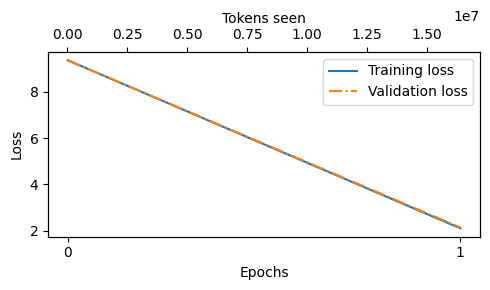

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)